# Building Models in Pytorch

Both ML frameworks Pytorch and Keras / TF offer the possibility to build simple NN models by stacking layers, in order to play with toy datasets.

This exercise allows you to quickly interact with the features offered by both frameworks, and sometimes they are enough to tackle simple daily basic problems for regression or classification.

Pytorch offers "torch.nn.Sequential" while in Keras you have "keras.Sequential", they both opperate similarly by stacking layers of different types

However for defining new architectures or tackle problems with different input or output types, it is needed more flexibility.

In Pytorch this flexibility is offered by subclassing the nn.Module, while in Keras it can be used the Functional API and model Subclassing (similar to Pytorch)

In [4]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

import matplotlib.pyplot as plt 
import numpy as np

torch.manual_seed(1)
np.random.seed(1)

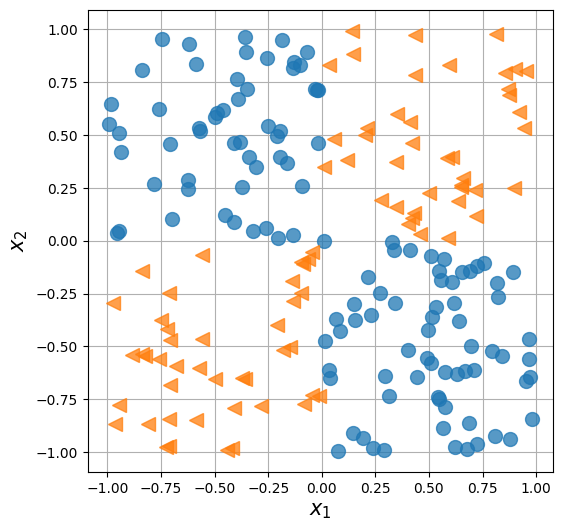

In [3]:
# XOR Classification Problem
x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1]<0] = 0
n_train = 100
x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)
fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0], x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)
plt.grid(True)
plt.show()


In [5]:
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
epochs = 200

train_dl = DataLoader(train_ds, batch_size, shuffle = True)

In [21]:
class myModelTorch(nn.Module):
    def __init__(self, inputs, outputs):
        super().__init__() #Hierate nn.Module
        inputs = inputs
        outputs = outputs
        layer1 = nn.Linear(inputs,  4)
        act1 = nn.ReLU()
        layer2 = nn.Linear(4,4)
        act2 = nn.ReLU()
        layer3 = nn.Linear(4,outputs)
        act3 = nn.Sigmoid()
        # All layers ara added into a nn.ModuleList object
        total_layers = [layer1, act1, layer2, act2, layer3, act3]
        self.module_list = nn.ModuleList(total_layers)
    
    # Define forward pass function
    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x
        

In [22]:
model = myModelTorch(2, 1)
model.eval

<bound method Module.eval of myModelTorch(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)>

In [30]:
class myModelTorchV2(nn.Module):
    def __init__(self, inputs, outputs):
        super().__init__() #Hierate nn.Module
        inputs = inputs
        outputs = outputs
        layer1 = nn.Linear(inputs,  4)
        act1 = nn.ReLU()
        layer2 = nn.Linear(4,4)
        act2 = nn.ReLU()
        layer3 = nn.Linear(4,outputs)
        act3 = nn.Sigmoid()
        # All layers ara added into a nn.ModuleList object
        total_layers = [layer1, act1, layer2, act2, layer3, act3]
        self.module_list = nn.ModuleList(total_layers)
    
    # Define forward pass function
    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:,0]
        return (pred >= 0.5).float()

In [24]:
model2 = myModelTorchV2(2, 1)
model2.eval

<bound method Module.eval of myModelTorchV2(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)>

In [27]:
loss_fn = nn.BCELoss()
optim = torch.optim.SGD(model2.parameters(), lr = 0.015)

In [29]:
def train(model, num_epochs, train_dl, x_valid, y_valid):
     loss_hist_train = [0] * num_epochs
     accuracy_hist_train = [0] * num_epochs
     loss_hist_valid = [0] * num_epochs
     accuracy_hist_valid = [0] * num_epochs
     for epoch in range(num_epochs):
         # Train Pass
         for x_batch, y_batch in train_dl:
             pred = model(x_batch)[:, 0]
             loss = loss_fn(pred, y_batch)
             loss.backward()
             optim.step()
             optim.zero_grad()
             loss_hist_train[epoch] += loss.item()
             is_correct = ((pred>=0.5).float() == y_batch).float()
             accuracy_hist_train[epoch] += is_correct.mean()
             
         # Validation Pass
         loss_hist_train[epoch] /= n_train/batch_size
         accuracy_hist_train[epoch] /= n_train/batch_size
         pred = model(x_valid)[:, 0]
         loss = loss_fn(pred, y_valid)
         loss_hist_valid[epoch] = loss.item()
         is_correct = ((pred>=0.5).float() == y_valid).float()
         accuracy_hist_valid[epoch] += is_correct.mean()
     return loss_hist_train, loss_hist_valid, \
            accuracy_hist_train, accuracy_hist_valid
history = train(model2, epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

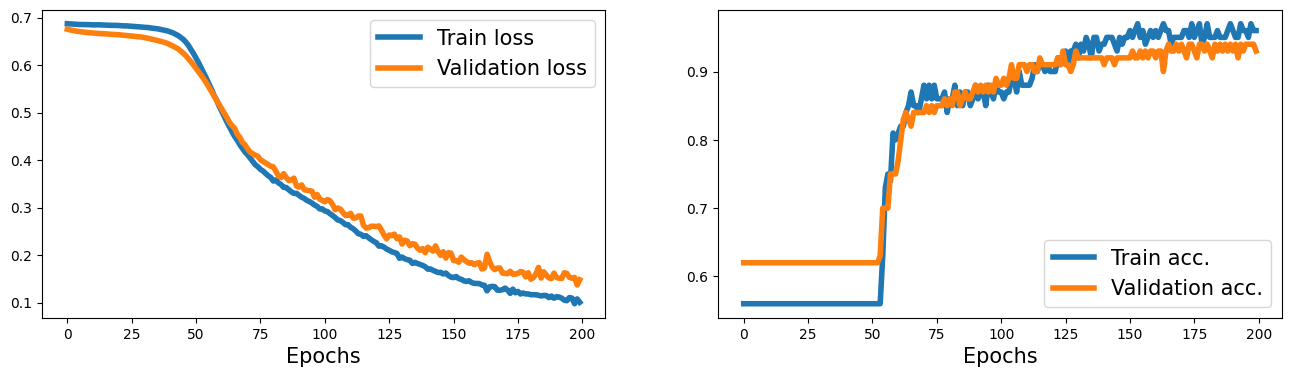

In [31]:
# plot training and validation curves from history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

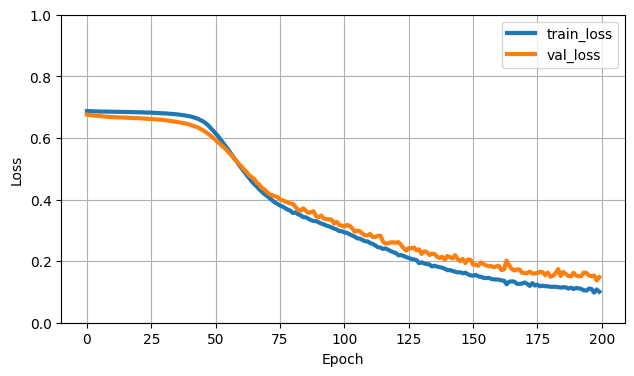

In [43]:
def plot_loss_torch(history):
  fig = plt.figure(figsize=(16, 4))
  ax = fig.add_subplot(1, 2, 1)
  plt.plot(history[0], label='train_loss',lw = 3)
  plt.plot(history[1], label='val_loss',lw = 3)
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()


plot_loss_torch(history)

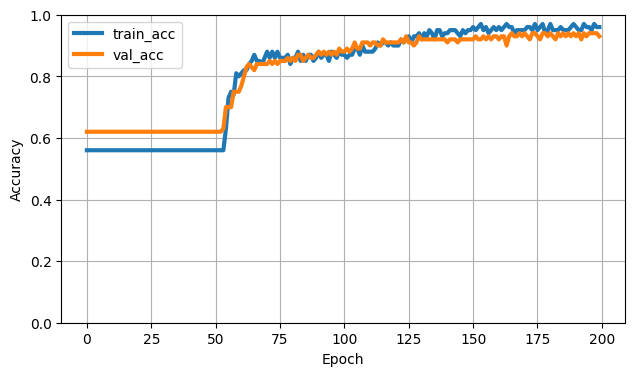

In [45]:
def plot_accuracy_torch(history):
  fig = plt.figure(figsize=(16, 4))
  ax = fig.add_subplot(1, 2, 1)
  plt.plot(history[2], label='train_acc',lw = 3)
  plt.plot(history[3], label='val_acc',lw = 3)
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()


plot_accuracy_torch(history)

## Custom Layers in Pytorch

Custom Layers in Pytorch are built from nn.Module, while in Keras you need to subclass keras.layers.Layers

In [47]:
class NoisyLinear(nn.Module):
    def __init__(self, input_size, output_size, noise_stddev=0.1):
        super().__init__()
        w = torch.Tensor(input_size, output_size)
        self.w = nn.Parameter(w)  # nn.Parameter is a Tensor that's a module parameter.
        nn.init.xavier_uniform_(self.w)
        b = torch.Tensor(output_size).fill_(0)
        self.b = nn.Parameter(b)
        self.noise_stddev = noise_stddev

    def forward(self, x, training=False):
        # Different behaviour if training or test
        if training:
            noise = torch.normal(0.0, self.noise_stddev, x.shape)
            x_new = torch.add(x, noise)
        else:
            x_new = x
        return torch.add(torch.mm(x_new, self.w), self.b)   

In [48]:
class MyNoisyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = NoisyLinear(2, 4, 0.07)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(4, 4)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(4, 1)
        self.a3 = nn.Sigmoid()
        
    def forward(self, x, training=False):
        x = self.l1(x, training)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)
        x = self.l3(x)
        x = self.a3(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()

torch.manual_seed(1)
model = MyNoisyModule()
model

MyNoisyModule(
  (l1): NoisyLinear()
  (a1): ReLU()
  (l2): Linear(in_features=4, out_features=4, bias=True)
  (a2): ReLU()
  (l3): Linear(in_features=4, out_features=1, bias=True)
  (a3): Sigmoid()
)

A similar example to this of a custom layer with added noise but in Keras, can be found in Ageron´s Github:

https://github.com/ageron/handson-ml3/blob/main/12_custom_models_and_training_with_tensorflow.ipynb

class MyGaussianNoise(tf.keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

# extra code – tests MyGaussianNoise
tf.random.set_seed(42)
model = tf.keras.Sequential([
    MyGaussianNoise(stddev=1.0, input_shape=input_shape),
    tf.keras.layers.Dense(30, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

In [50]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
    
torch.manual_seed(1)

loss_hist_train = [0] * epochs
accuracy_hist_train = [0] * epochs
loss_hist_valid = [0] * epochs
accuracy_hist_valid = [0] * epochs
for epoch in range(epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch, True)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train[epoch] += loss.item()
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_hist_train[epoch] += is_correct.mean()

    loss_hist_train[epoch] /= n_train/batch_size
    accuracy_hist_train[epoch] /= n_train/batch_size

    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred>=0.5).float() == y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()

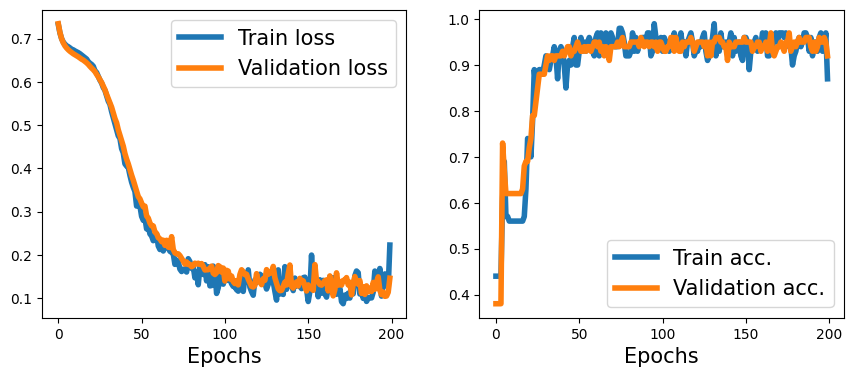

In [55]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(loss_hist_train, lw=4)
plt.plot(loss_hist_valid, lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(accuracy_hist_train, lw=4)
plt.plot(accuracy_hist_valid, lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)


plt.show()